In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

df = pd.read_csv("../data/freq_data.csv")
df = df[(df["Exposure"] > 0) & (df["Exposure"] <= 1)].copy()

# target
y = df["ClaimNb"].astype(float)

# drop ClaimNb AND IDpol (IDpol is just an identifier, not a feature)
X = df.drop(columns=["ClaimNb", "IDpol"])



In [3]:
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float).fillna(0.0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:
cat_features = []  # already encoded

cat_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.05,
    iterations=300,
    loss_function="MAE",
    verbose=False
)

cat_model.fit(X_train, y_train)

cat_pred = cat_model.predict(X_test)

cat_mae = mean_absolute_error(y_test, cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))

cat_mae, cat_rmse


(0.05240681083004479, 0.24291233229819098)

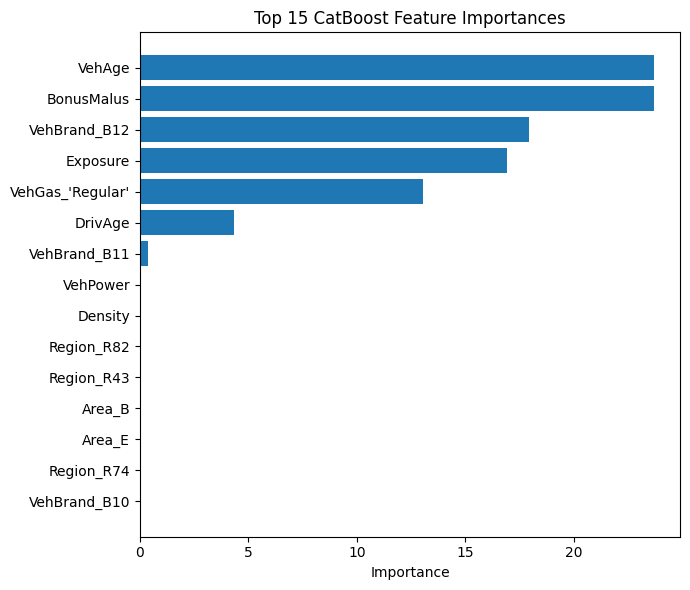

In [11]:
import numpy as np
import matplotlib.pyplot as plt

importance = cat_model.get_feature_importance()
feature_names = np.array(X_train.columns)

# select top 15 features
top_n = 15
sorted_idx = np.argsort(importance)[-top_n:]

plt.figure(figsize=(7, 6))
plt.barh(feature_names[sorted_idx], importance[sorted_idx])
plt.title("Top 15 CatBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()

# SAVE new figure (overwrites the old one if it exists)
plt.savefig("../figures/catboost_feature_importance.png", dpi=150)

plt.show()


In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist'
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

xgb_mae, xgb_rmse


(0.09614077168709245, 0.23191710224097725)

In [7]:
import os
os.makedirs("../outputs", exist_ok=True)


In [8]:
cat_pred = cat_model.predict(X_test)


In [9]:
import pandas as pd

pred_df = pd.DataFrame({"pred": cat_pred})
pred_df.to_csv("../outputs/catboost_predictions.csv", index=False)

print("Saved CatBoost predictions to ../outputs/catboost_predictions.csv")


Saved CatBoost predictions to ../outputs/catboost_predictions.csv


In [10]:
import os
os.listdir("../outputs")


['catboost_predictions.csv']